In [1]:
from datasets import load_dataset

cifar_10_test = load_dataset('cifar10', split='test')

In [2]:
for _ in cifar_10_test.select(range(10)):
    print(_)

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7F5891C2B1F0>, 'label': 3}
{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7F5890261420>, 'label': 8}
{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7F5CACB33670>, 'label': 8}
{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7F5890261420>, 'label': 0}
{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7F5CACB33640>, 'label': 6}
{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7F5890261420>, 'label': 6}
{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7F5CACB33580>, 'label': 1}
{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7F5890261420>, 'label': 6}
{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7F5CACB30670>, 'label': 3}
{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7F5890261420>, 'label': 1}


In [3]:
labels = cifar_10_test.features['label'].names
label_id_dict = dict(zip(labels, range(len(labels))))
id_label_dict = dict(zip(range(len(labels)), labels))

In [4]:
labels

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [5]:
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel, CLIPImageProcessor, AutoTokenizer
import numpy as np

In [6]:
prompt = [f"a photo of a {label}" for label in labels]

In [7]:
prompt

['a photo of a airplane',
 'a photo of a automobile',
 'a photo of a bird',
 'a photo of a cat',
 'a photo of a deer',
 'a photo of a dog',
 'a photo of a frog',
 'a photo of a horse',
 'a photo of a ship',
 'a photo of a truck']

In [9]:
model_path = "/data-ai/usr/lmj/models/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_path)
processor = CLIPProcessor.from_pretrained(model_path)

In [10]:
model.config

CLIPConfig {
  "_name_or_path": "/data-ai/usr/lmj/models/clip-vit-base-patch32",
  "architectures": [
    "CLIPModel"
  ],
  "initializer_factor": 1.0,
  "logit_scale_init_value": 2.6592,
  "model_type": "clip",
  "projection_dim": 512,
  "text_config": {
    "bos_token_id": 0,
    "dropout": 0.0,
    "eos_token_id": 2,
    "model_type": "clip_text_model"
  },
  "transformers_version": "4.36.2",
  "vision_config": {
    "dropout": 0.0,
    "model_type": "clip_vision_model"
  }
}

In [11]:
def get_image_predict_label(images):
    inputs = processor(text=prompt, images=images, return_tensors="pt", padding=True)
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image
    probs = logits_per_image.softmax(dim=1)
    label_ids = np.argmax(probs.detach().numpy(), axis=1).tolist()
    return [id_label_dict[label_id] for label_id in label_ids]

In [12]:
images = [_['img'] for _ in cifar_10_test.select(range(5))]
images

[<PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>]

In [13]:
test_labels = get_image_predict_label(images=images)
test_labels

['cat', 'ship', 'ship', 'airplane', 'frog']

In [14]:
from sklearn.metrics import classification_report
from tqdm import tqdm
import time

y_true = []
y_pred = []

s_time = time.time()
batch_size = 32
start = 0
end = batch_size
while start < len(cifar_10_test):
    sample = cifar_10_test[start:end]
    img_list, label_id_list = sample['img'], sample['label']
    y_true.extend([id_label_dict[label_id] for label_id in label_id_list])
    y_pred.extend(get_image_predict_label(images=img_list))
    start = end
    end += batch_size
    print(start, end)
print('cost time: ', time.time() - s_time)

32 64
64 96
96 128
128 160
160 192
192 224
224 256
256 288
288 320
320 352
352 384
384 416
416 448
448 480
480 512
512 544
544 576
576 608
608 640
640 672
672 704
704 736
736 768
768 800
800 832
832 864
864 896
896 928
928 960
960 992
992 1024
1024 1056
1056 1088
1088 1120
1120 1152
1152 1184
1184 1216
1216 1248
1248 1280
1280 1312
1312 1344
1344 1376
1376 1408
1408 1440
1440 1472
1472 1504
1504 1536
1536 1568
1568 1600
1600 1632
1632 1664
1664 1696
1696 1728
1728 1760
1760 1792
1792 1824
1824 1856
1856 1888
1888 1920
1920 1952
1952 1984
1984 2016
2016 2048
2048 2080
2080 2112
2112 2144
2144 2176
2176 2208
2208 2240
2240 2272
2272 2304
2304 2336
2336 2368
2368 2400
2400 2432
2432 2464
2464 2496
2496 2528
2528 2560
2560 2592
2592 2624
2624 2656
2656 2688
2688 2720
2720 2752
2752 2784
2784 2816
2816 2848
2848 2880
2880 2912
2912 2944
2944 2976
2976 3008
3008 3040
3040 3072
3072 3104
3104 3136
3136 3168
3168 3200
3200 3232
3232 3264
3264 3296
3296 3328
3328 3360
3360 3392
3392 3424
3424 3

In [46]:
print(classification_report(y_true, y_pred, target_names=labels, digits=4))

              precision    recall  f1-score   support

    airplane     0.9504    0.9010    0.9251      1000
  automobile     0.8785    0.9760    0.9247      1000
        bird     0.8124    0.8880    0.8485      1000
         cat     0.8190    0.8600    0.8390      1000
        deer     0.9341    0.7650    0.8411      1000
         dog     0.8508    0.8840    0.8671      1000
        frog     0.9699    0.7740    0.8610      1000
       horse     0.8127    0.9760    0.8869      1000
        ship     0.9446    0.9550    0.9498      1000
       truck     0.9688    0.9010    0.9337      1000

    accuracy                         0.8880     10000
   macro avg     0.8941    0.8880    0.8877     10000
weighted avg     0.8941    0.8880    0.8877     10000



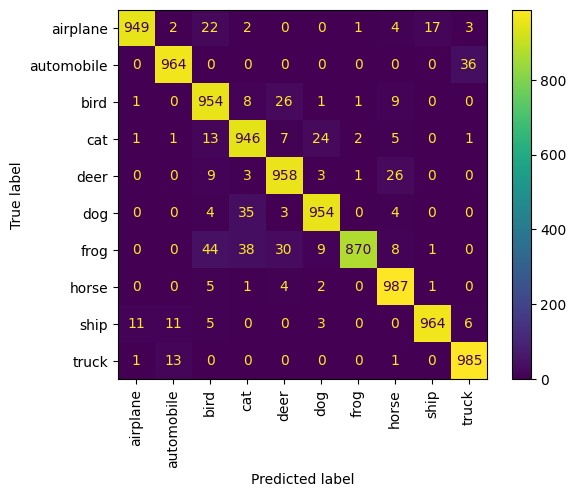

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation="vertical")